<a href="https://colab.research.google.com/github/yaphetsyaphets/Machine_Learning/blob/main/Neural_Network_SMS_Text_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-02-22 14:15:59--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.1s    

2024-02-22 14:16:00 (2.36 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-02-22 14:16:00--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
train_df = pd.read_csv(train_file_path,sep="\t",header=None, names= ['type','msg'])
train_df.dropna()
train_df.head(3)

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."


In [ ]:
test_df = pd.read_csv(test_file_path,sep='\t',header = None, names=['type','msg'])
test_df.dropna()
test_df.head(3)

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...


In [ ]:
train_df['type'] = pd.factorize(train_df['type'])[0]
test_df['type']= pd.factorize(test_df['type'])[0]

In [ ]:
train_labels = train_df['type'].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['msg'].values,train_labels)
)

In [ ]:
test_labels = test_df['type'].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['msg'].values,test_labels)
)

In [ ]:
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
vec = TextVectorization(
    output_mode = 'int',
    max_tokens = 1000,
    output_sequence_length = 1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
131/131 [==============================] - 62s 283ms/step - loss: 0.6051 - accuracy: 0.8660 - val_loss: 0.4856 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 24s 186ms/step - loss: 0.3639 - accuracy: 0.8660 - val_loss: 0.2103 - val_accuracy: 0.8604
Epoch 3/10
131/131 [==============================] - 21s 160ms/step - loss: 0.1387 - accuracy: 0.9502 - val_loss: 0.0978 - val_accuracy: 0.9698
Epoch 4/10
131/131 [==============================] - 21s 160ms/step - loss: 0.0795 - accuracy: 0.9825 - val_loss: 0.0726 - val_accuracy: 0.9802
Epoch 5/10
131/131 [==============================] - 22s 167ms/step - loss: 0.0601 - accuracy: 0.9868 - val_loss: 0.0649 - val_accuracy: 0.9833
Epoch 6/10
131/131 [==============================] - 20s 154ms/step - loss: 0.0502 - accuracy: 0.9883 - val_loss: 0.0626 - val_accuracy: 0.9844
Epoch 7/10
131/131 [==============================] - 21s 160ms/step - loss: 0.0390 - accuracy: 0.9916 - val_loss: 0.0629 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 1s 14ms/step - loss: 0.0707 - accuracy: 0.9842


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.07074131816625595
Test Accuracy: 0.9841954112052917


In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.6342426788061857)

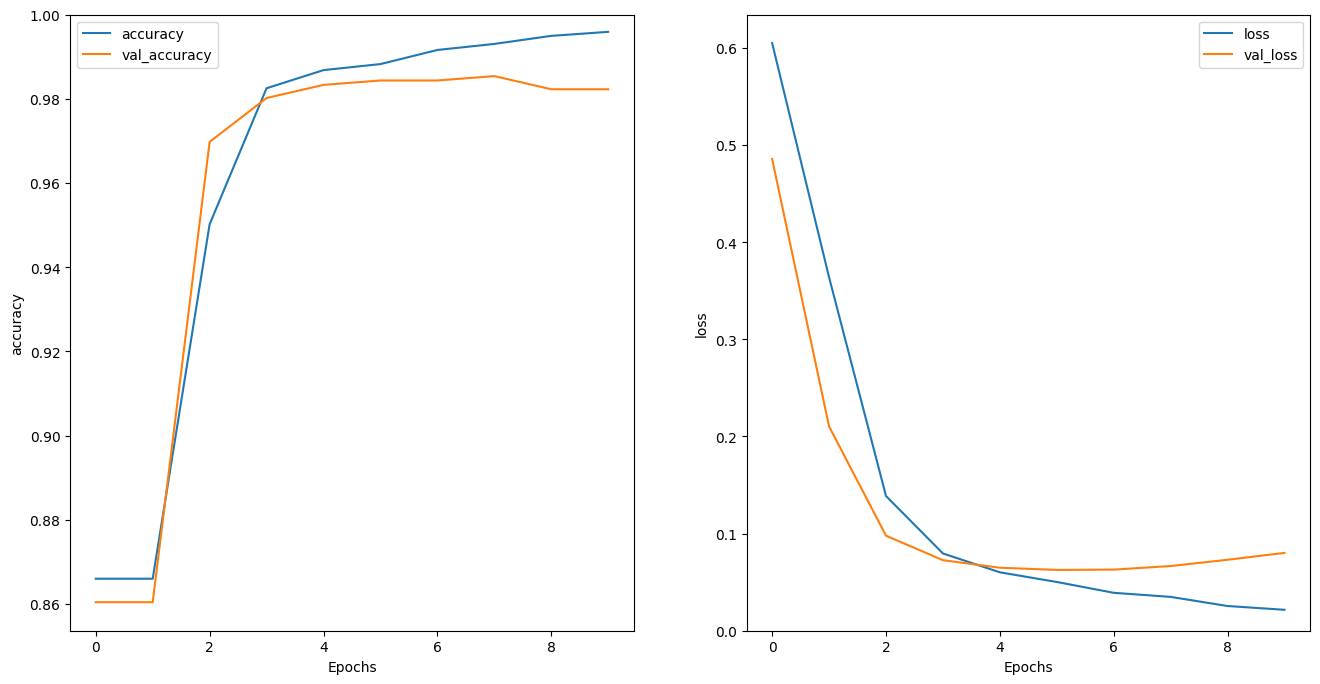

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6050665378570557, 0.3639039695262909, 0.1387110948562622, 0.07954432815313339, 0.060148727148771286, 0.05018211901187897, 0.03903625160455704, 0.03483103960752487, 0.025430012494325638, 0.0215437188744545]
[0.4856449067592621, 0.210306316614151, 0.09782931208610535, 0.07264410704374313, 0.06486454606056213, 0.0626126155257225, 0.06291592121124268, 0.06661135703325272, 0.0730653628706932, 0.0801534429192543]
[0.8659966588020325, 0.8659966588020325, 0.9502273201942444, 0.982531726360321, 0.9868389368057251, 0.9882746934890747, 0.9916247725486755, 0.9930605292320251, 0.9949748516082764, 0.9959320425987244]
[0.8604166507720947, 0.8604166507720947, 0.9697916507720947, 0.9802083373069763, 0.9833333492279053, 0.984375, 0.984375, 0.9854166507720947, 0.9822916388511658, 0.9822916388511658]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 7s 7s/step
[[-6.5569396]]
[-6.5569396, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 37ms/step
[[-6.5569396]]
1/1 [==============================] - 0s 36ms/step
[[1.8332236]]
1/1 [==============================] - 0s 41ms/step
[[-10.561626]]
1/1 [==============================] - 0s 69ms/step
[[4.4330397]]
1/1 [==============================] - 0s 61ms/step
[[5.35059]]
1/1 [==============================] - 0s 56ms/step
[[-9.67509]]
1/1 [==============================] - 0s 77ms/step
[[-9.631832]]
You passed the challenge. Great job!
